### entrainement sur les donnee de lundi

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model

# Charger les données du lundi
df = pd.read_csv("Monday-WorkingHours.pcap_ISCX.csv")

# Nettoyage : supprimer les colonnes non numériques
df = df.select_dtypes(include=[np.number])

# Supprimer les colonnes contenant des valeurs infinies ou NaN
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Normaliser les données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Définir l'autoencoder
input_dim = data_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(encoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Entraîner le modèle
# autoencoder.fit(data_scaled, data_scaled, epochs=10, batch_size=32, shuffle=True)
# Modification dans la partie entraînement :
history = autoencoder.fit(
    data_scaled, 
    data_scaled, 
    epochs=10, 
    batch_size=32, 
    shuffle=True
)

# Sauvegarder l'historique des erreurs
np.save("training_errors.npy", history.history['loss'])

#! Sauvegarder le modèle et le scaler
autoencoder.save("autoencoder_model.keras")
np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

2025-05-01 16:26:40.253307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 16:26:40.367506: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 16:26:40.411632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746109600.499412   44874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746109600.518600   44874 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746109600.677616   44874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.3593
Epoch 2/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.1870
Epoch 3/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.1839
Epoch 4/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.1857
Epoch 5/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.2036
Epoch 6/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.1428
Epoch 7/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.1463
Epoch 8/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1413
Epoch 9/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1709
Epoch 10/10
16547/16547 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1633


### detection sur les autre fichier

/home/neo/Desktop/IPS/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


7054/7054 ━━━━━━━━━━━━━━━━━━━━ 6s 822us/step
Seuil optimal trouvé : 0.0007 avec F1-score : 0.6041
Confusion Matrix :
[[     1  97685]
 [     0 128025]]

Classification Report :
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.00     97686
    Anomalie       0.57      1.00      0.72    128025

    accuracy                           0.57    225711
   macro avg       0.78      0.50      0.36    225711
weighted avg       0.75      0.57      0.41    225711



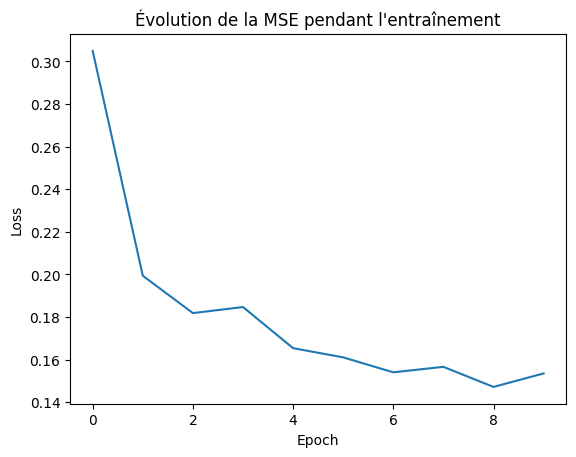

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Charger les données brutes (y compris la colonne Label)
df_raw = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_raw.columns = df_raw.columns.str.strip()  # Nettoyer les noms de colonnes

# Garder uniquement les colonnes numériques pour le modèle
features = df_raw.select_dtypes(include=[np.number])
features = features.replace([np.inf, -np.inf], np.nan).dropna()

# Récupérer les labels en se basant sur les mêmes index que les features nettoyées
labels = df_raw.loc[features.index, 'Label']

# Charger le scaler sauvegardé
mean = np.load("scaler_mean.npy")
scale = np.load("scaler_scale.npy")
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

# Normaliser les données
data_scaled = scaler.transform(features)

# Charger le modèle autoencoder
autoencoder = load_model("autoencoder_model.keras")

# Faire les prédictions (reconstruction)
reconstructions = autoencoder.predict(data_scaled)
mse = np.mean(np.power(data_scaled - reconstructions, 2), axis=1)

# Recherche du meilleur seuil basé sur un compromis entre precision et recall (par exemple, F1-score)
best_f1 = 0
best_threshold = 0
for t in np.linspace(min(mse), max(mse), 100):
    predicted = np.where(mse > t, 1, 0)
    f1 = f1_score(labels.str.contains("BENIGN").astype(int), predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Seuil optimal trouvé : {best_threshold:.4f} avec F1-score : {best_f1:.4f}")

# Appliquer ce seuil pour obtenir les prédictions
predicted = np.where(mse > best_threshold, 1, 0)
true_labels = np.where(labels.str.contains("BENIGN"), 0, 1)

# Afficher les résultats
print("Confusion Matrix :")
print(confusion_matrix(true_labels, predicted))
print("\nClassification Report :")
print(classification_report(true_labels, predicted, target_names=["Normal", "Anomalie"]))

# analyser eureurs d'entraînement
import matplotlib.pyplot as plt
training_errors = np.load("training_errors.npy")
plt.plot(training_errors)
plt.title("Évolution de la MSE pendant l'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("training_loss.png")  # Sauvegarde l'image
plt.show()  # Affiche le graphique

### visualisation

/home/neo/Desktop/IPS/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


7054/7054 ━━━━━━━━━━━━━━━━━━━━ 5s 748us/step


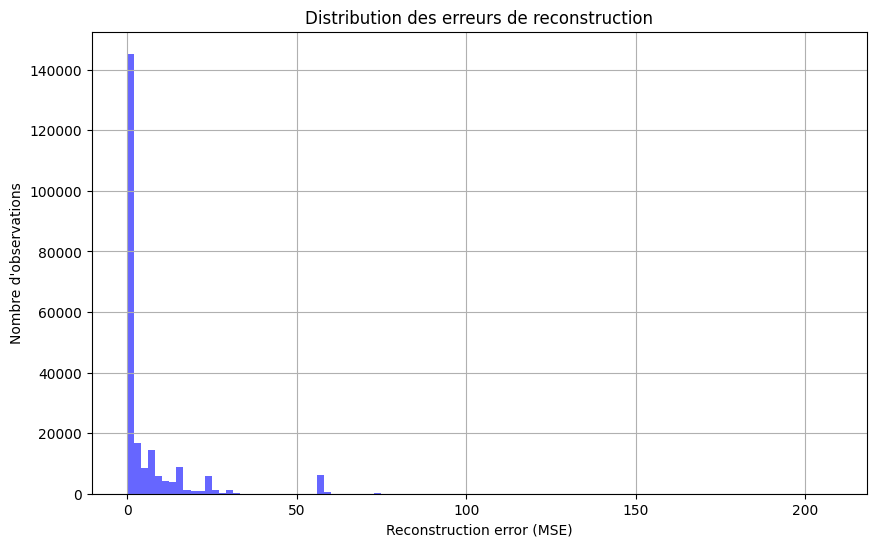

In [22]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import load_model
# Exemple : charger un fichier de test avec du trafic mixte
df_test = pd.read_csv("/home/neo/Desktop/IPS/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")  # par exemple
df_test = df_test.select_dtypes(include=[np.number])
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()

# Appliquer le même scaler
# Appliquer le même scaler
scaler = StandardScaler()  # <-- ligne manquante
mean = np.load("scaler_mean.npy")
scale = np.load("scaler_scale.npy")
scaler.mean_ = mean
scaler.scale_ = scale
data_test_scaled = scaler.transform(df_test)

#! Charger le modèle
autoencoder = load_model("autoencoder_model.keras")

# Prédire
reconstructions = autoencoder.predict(data_test_scaled)
mse = np.mean(np.power(data_test_scaled - reconstructions, 2), axis=1)

# Visualiser l'erreur
plt.figure(figsize=(10,6))
plt.hist(mse, bins=100, color='blue', alpha=0.6)
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des erreurs de reconstruction")
plt.grid(True)
plt.show()


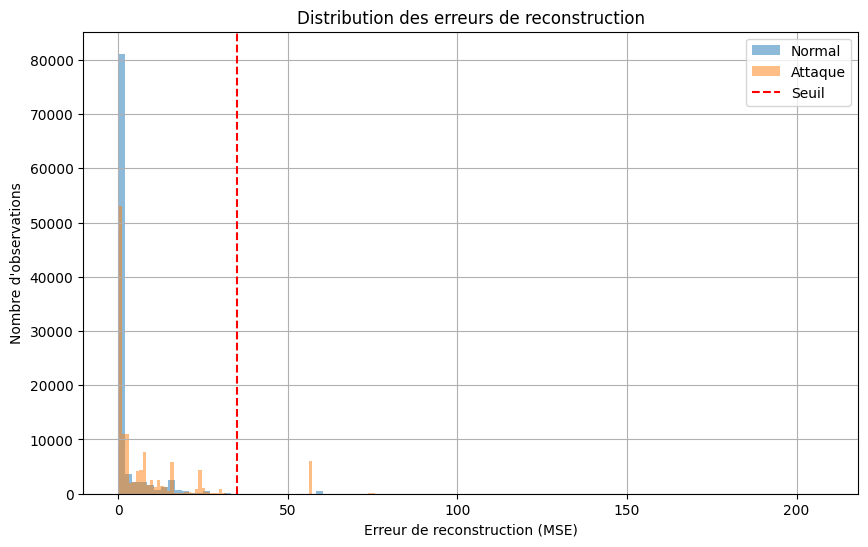

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(mse[true_labels == 0], bins=100, alpha=0.5, label='Normal')
plt.hist(mse[true_labels == 1], bins=100, alpha=0.5, label='Attaque')
plt.axvline(threshold, color='red', linestyle='--', label='Seuil')
plt.xlabel("Erreur de reconstruction (MSE)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des erreurs de reconstruction")
plt.legend()
plt.grid(True)
plt.show()


#  anayser eureur